# Imports

In [1]:
import math
import glob
import os

import pandas as pd
import numpy as np
import plotly.express as px

from pyathena import connect
from pyathena.common import BaseCursor
from pyathena.pandas.cursor import PandasCursor
from joblib import Parallel, delayed
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.arima.model import ARIMA
from dataclasses import dataclass
from tqdm.auto import tqdm
from sklearn.metrics import r2_score

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# Helper methods

In [3]:
# # Legacy way
# data_path = "/home/tomm/Downloads/Stonks/Data/GME.csv"
# data_path = "/home/tomm/Downloads/Stonks/Data/TSLA.csv"
# df = pd.read_csv(data_path)

found_files = glob.glob(os.path.join("", "/home/tomm/Downloads/Stonks/Data/*.parquet"))
dfs = []
found_tickers = []
for file in tqdm(found_files):
    df = pd.read_parquet(file)
    ticker = file.split("ticker=")[1].split(".parquet")[0]
    df["ticker"] = ticker
    found_tickers.append(ticker)   
    dfs.append(df)

df_original = pd.concat(dfs)
df_original.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2016-03-28,28.120001,28.219999,27.690001,28.090000,26.426308,6378200,SCHW
1,2016-03-29,27.799999,28.090000,27.559999,28.020000,26.360449,8661700,SCHW
2,2016-03-30,28.250000,28.549999,27.840000,28.170000,26.501564,6563000,SCHW
3,2016-03-31,28.150000,28.330000,27.950001,28.020000,26.360449,7809700,SCHW
4,2016-04-01,27.740000,28.450001,27.510000,28.379999,26.699129,6896200,SCHW


In [4]:
# Yahoo prices
col_close = "Close"
col_open = "Open"
col_high = "High"
col_low = "Low"

acceptable_gain = 0.25

In [5]:
def check_for_peak(row):
    return (
        (row["3_shift"] > row["4_shift"]) and
        (row["2_shift"] > row["3_shift"]) and
        (row["1_shift"] < row["2_shift"]) and
        (row[col_close] < row["1_shift"])
    )

def check_for_dip(row):
    return (
        (row["3_shift"] < row["4_shift"]) and
        (row["2_shift"] < row["3_shift"]) and
        (row["1_shift"] > row["2_shift"]) and
        (row[col_close] > row["1_shift"])
    )

In [42]:
dfs_augmented = []

for ticker in tqdm(df_original["ticker"].unique()):
    df = df_original.loc[df_original["ticker"] == ticker]

    # Raw differences
    df["OC-Difference"] = df[col_close] - df[col_open]
    df["HL-Difference"] = df[col_high] - df[col_low]

    # Percent differences
    df["OCCandle"] = 100.0 * (df[col_close] / df[col_open]) - 100.0
    df["HLCandle"] = 100.0 * (df[col_high] / df[col_low]) - 100.0

    # # Gains calculation - raw
    # df["Gains01Days"] = ((df[col_close].shift(-1) / df[col_close]) * buy_in_amount) - buy_in_amount
    # df["Gains07Days"] = ((df[col_close].shift(-7) / df[col_close]) * buy_in_amount) - buy_in_amount 
    # df["Gains28Days"] = ((df[col_close].shift(-28) / df[col_close]) * buy_in_amount) - buy_in_amount 
    # df["Gains100Days"] = ((df[col_close].shift(-100) / df[col_close]) * buy_in_amount) - buy_in_amount

    # # Turning points
    # df["WasDown"] = (df[col_close] > df[col_close].shift(1)).astype(int)
    # df["WasUp"] = (df[col_close] < df[col_close].shift(1)).astype(int)
    # df["GoingDown"] = (df[col_close] > df[col_close].shift(-1)).astype(int)
    # df["GoingUp"] = (df[col_close] < df[col_close].shift(-1)).astype(int)
    # df["Peak"] = (df["GoingDown"] + df["WasDown"] > 1).astype(int)
    # df["Dip"] = (df["GoingUp"] + df["WasUp"] > 1).astype(int) * -1

    # Find turning fractals
    df["6_shift"] = df[col_close].shift(6)
    df["5_shift"] = df[col_close].shift(5)
    df["4_shift"] = df[col_close].shift(4)
    df["3_shift"] = df[col_close].shift(3)
    df["2_shift"] = df[col_close].shift(2)
    df["1_shift"] = df[col_close].shift(1)
    df["just_peaked"] = df.apply(lambda row: check_for_peak(row), axis=1)
    df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
    df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
    df["recently_dipped"] = df["just_dipped"].rolling(5).sum() > 0

    # Momentum calculations
    df["Momentum_05"] = df["OCCandle"].rolling(5).mean()
    df["Momentum_10"] = df["OCCandle"].rolling(10).mean()
    df["Momentum_20"] = df["OCCandle"].rolling(20).mean()
    df["Momentum_30"] = df["OCCandle"].rolling(30).mean()

    # Volume caclulations
    df["Vol_Rolling_05"] = df["Volume"].rolling(5).sum()
    df["Vol_TodayShiftAsPercentOf5DaySum"] = 100.0 * (df["Volume"] / df["Vol_Rolling_05"])
    
    # TODO: Relative Strength Index (RSI)
    
    # TODO: Moving Average Convergence Divergence (MACD)
    
    
    
    df["target"] = df[col_close] < ((1 - 0.1) * df[col_close].shift(-10))
    # Target column - Generating heaps for now to get a better picture
#     for i in tqdm(range(1, 300)):
#         df[f"MakesBigMoney_{i}Days"] = df[col_close] < ((1 - acceptable_gain) * df[col_close].shift(-i))
    
    dfs_augmented.append(df)

df_augmented = pd.concat(dfs_augmented)
df_augmented.sort_values(["Date"], inplace=True)
df_augmented.reset_index(inplace=True, drop=True)

<ipython-input-42-63f8b52b0111>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OC-Difference"] = df[col_close] - df[col_open]
<ipython-input-42-63f8b52b0111>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["HL-Difference"] = df[col_high] - df[col_low]
<ipython-input-42-63f8b52b0111>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<ipython-input-42-63f8b52b0111>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df[col_close] < ((1 - 0.1) * df[col_close].shift(-10))
<ipython-input-42-63f8b52b0111>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OC-Difference"] = df[col_close] - df[col_open]
<ipython-input-42-63f8b52b0111>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Momentum_10"] = df["OCCandle"].rolling(10).mean()
<ipython-input-42-63f8b52b0111>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Momentum_20"] = df["OCCandle"].rolling(20).mean()
<ipython-input-42-63f8b52b0111>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_peaked"] = df.apply(lambda row: check_for_peak(row), axis=1)
<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_peaked"] = df.apply(lambda row: check_for_peak(row), axis=1)
<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_peaked"] = df.apply(lambda row: check_for_peak(row), axis=1)
<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_dipped"] = df["just_dipped"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["recently_peaked"] = df["just_peaked"].rolling(5).sum() > 0
<ipython-input-42-63f8b52b0111>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-42-63f8b52b0111>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_peaked"] = df.apply(lambda row: check_for_peak(row), axis=1)
<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

<ipython-input-42-63f8b52b0111>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_peaked"] = df.apply(lambda row: check_for_peak(row), axis=1)
<ipython-input-42-63f8b52b0111>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["just_dipped"] = df.apply(lambda row: check_for_dip(row), axis=1)
<ipython-input-42-63f8b52b0111>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [43]:
df_augmented.shape

(121607, 29)

In [44]:
df_augmented["target"].value_counts(normalize=True)

False    0.968324
True     0.031676
Name: target, dtype: float64

In [45]:
df_augmented.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,OC-Difference,HL-Difference,OCCandle,HLCandle,6_shift,5_shift,4_shift,3_shift,2_shift,1_shift,just_peaked,just_dipped,recently_peaked,recently_dipped,Momentum_05,Momentum_10,Momentum_20,Momentum_30,Vol_Rolling_05,Vol_TodayShiftAsPercentOf5DaySum,target
0,2016-03-28,28.120001,28.219999,27.690001,28.090000,26.426308,6378200,SCHW,-0.030001,0.529998,-0.106689,1.914041,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2016-03-28,124.000000,124.199997,123.120003,123.169998,108.383736,4784400,MCD,-0.830002,1.079994,-0.669356,0.877188,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2016-03-28,92.680000,92.830002,91.900002,92.400002,92.400002,2283000,ADBE,-0.279998,0.930000,-0.302113,1.011970,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2016-03-28,27.990000,28.030001,27.790001,27.900000,23.746363,12785900,CSCO,-0.090000,0.240000,-0.321543,0.863620,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2016-03-28,13.730000,13.740000,13.540000,13.620000,12.329511,54498500,BAC,-0.110000,0.200000,-0.801165,1.477105,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False


In [64]:
features = [
    "OCCandle",
    "HLCandle",
    "ticker",
    "just_peaked",
    "just_dipped",
    "recently_peaked",
    "recently_dipped",
    "Momentum_05",
    "Momentum_10",
    "Momentum_20",
    "Momentum_30",
    "Vol_TodayShiftAsPercentOf5DaySum"
]

import lightgbm as lgb

total_size = df_augmented.shape[0]
df_augmented["ticker"] = df_augmented["ticker"].astype("category")

train_data = lgb.Dataset(
    df_augmented[features].iloc[:int(total_size * 0.7)], 
    label=df_augmented["target"].iloc[:int(total_size * 0.7)],
    categorical_feature=["ticker"]
)
valid_data = lgb.Dataset(
    df_augmented[features].iloc[int(total_size * 0.7):int(total_size * 0.8)], 
    label=df_augmented["target"].iloc[int(total_size * 0.7):int(total_size * 0.8)],
    categorical_feature=["ticker"]
)

In [65]:
param = {
    "num_leaves": 100,
    "objective": "binary",
    "metric": "auc"
}

num_rounds = 10_000
model = lgb.train(param, train_data, num_rounds, valid_sets=[valid_data], early_stopping_rounds=100)

/home/tomm/.pyenv/versions/3.8.3/envs/scratch/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/tomm/.pyenv/versions/3.8.3/envs/scratch/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/tomm/.pyenv/versions/3.8.3/envs/scratch/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 1469, number of negative: 83655
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 85124, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017257 -> initscore=-4.042119
[LightGBM] [Info] Start training from score -4.042119
[1]	valid_0's auc: 0.80371
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.816518
[3]	valid_0's auc: 0.823642
[4]	valid_0's auc: 0.829786
[5]	valid_0's auc: 0.828745
[6]	valid_0's auc: 0.832378
[7]	valid_0's auc: 0.829029
[8]	valid_0's auc: 0.826279
[9]	valid_0's auc: 0.825357
[10]	valid_0's auc: 0.824677
[11]	valid_0's auc: 0.821757
[12]	valid_0's auc: 0.820386
[13]	valid_0's auc: 0.821193
[14]	valid_

In [66]:
test_x = df_augmented[features].iloc[int(total_size * 0.9):] 
test_y = df_augmented["target"].iloc[int(total_size * 0.9):]

ypred = model.predict(test_x, num_iteration=model.best_iteration)

In [67]:
test_x["Date"] = df_augmented["Date"].iloc[int(total_size * 0.9):].values 
test_x["target"] = test_y
test_x["predicted"] = ypred
test_x.head()

,OCCandle,HLCandle,ticker,just_peaked,just_dipped,recently_peaked,recently_dipped,Momentum_05,Momentum_10,Momentum_20,Momentum_30,Vol_TodayShiftAsPercentOf5DaySum,Date,target,predicted
109446,0.267445,1.638196,ABBV,False,False,False,False,-0.693774,-0.381634,-0.422464,-0.335321,25.604709,2020-09-25,False,0.019320
109447,1.599751,2.501795,UNP,False,False,False,False,0.181942,0.283027,0.060148,0.085924,16.366348,2020-09-25,False,0.016886
109448,0.751071,2.209870,ACN,False,False,False,False,-0.587760,-0.291611,-0.371394,-0.160245,24.124994,2020-09-25,False,0.010028
109449,0.949480,1.760385,MRK,False,False,True,False,-0.125121,0.056444,-0.172777,-0.059189,17.137157,2020-09-25,False,0.010028
109450,0.549370,1.162096,WMT,False,False,False,False,0.084158,-0.080769,-0.262646,-0.080505,14.538120,2020-09-25,False,0.010573


In [68]:
test_x.loc[test_x["predicted"] >= 0.35].head(100)

,OCCandle,HLCandle,ticker,just_peaked,just_dipped,recently_peaked,recently_dipped,Momentum_05,Momentum_10,Momentum_20,Momentum_30,Vol_TodayShiftAsPercentOf5DaySum,Date,target,predicted
110749,-3.299016,5.986856,PDD,True,False,True,False,1.206257,0.610951,0.050366,-0.326402,11.311354,2020-10-14,False,0.575897
111014,-2.914843,4.301939,NVDA,False,False,True,True,-1.014050,-0.602051,0.120746,-0.133820,20.859437,2020-10-19,False,0.374978
112263,-0.624010,5.740158,PDD,False,False,False,False,1.364257,1.248633,1.230552,0.655573,21.367982,2020-11-05,True,0.380213
112476,-8.160174,10.070228,JD,False,False,False,False,-0.219850,-0.016515,-0.209241,-0.103878,24.345577,2020-11-09,False,0.537066
112512,-2.701616,5.683921,AMZN,True,False,True,True,0.224350,-0.505415,-0.650612,-0.285100,24.487210,2020-11-09,False,0.416555
112655,8.783916,12.864391,PDD,False,False,True,False,1.001803,1.480316,1.102682,0.938772,27.629828,2020-11-11,True,0.484497
112730,-0.861509,3.349082,NFLX,False,False,False,False,-0.086459,-0.235436,-0.425293,-0.373156,15.121706,2020-11-12,False,0.424624
112808,4.530727,4.789881,BA,False,False,True,False,0.526348,0.870573,-0.170178,-0.407123,11.929703,2020-11-13,True,0.549117
112831,7.511364,10.644199,PDD,False,False,True,True,1.928783,2.093309,1.181295,1.149447,32.039243,2020-11-13,False,0.476199
112963,-3.661015,6.477296,JD,False,False,True,True,-0.381955,-0.300903,-0.112781,-0.127808,26.356263,2020-11-16,False,0.516489


In [70]:
test_x.loc[test_x["target"] == True].head(100)

,OCCandle,HLCandle,ticker,just_peaked,just_dipped,recently_peaked,recently_dipped,Momentum_05,Momentum_10,Momentum_20,Momentum_30,Vol_TodayShiftAsPercentOf5DaySum,Date,target,predicted
109457,1.401421,2.220502,BUD,False,False,True,False,-0.400613,-0.302189,-0.409226,-0.200355,16.998161,2020-09-25,True,0.011935
109472,2.788251,3.295133,BLK,False,False,False,False,0.178537,0.258510,-0.422963,-0.298537,17.522876,2020-09-25,True,0.012246
109489,4.480756,5.493914,SHOP,False,False,True,True,1.591507,0.585475,-0.421920,-0.151658,19.468470,2020-09-25,True,0.075761
109506,1.789665,3.598059,NFLX,False,False,False,True,0.563278,-0.042309,-0.384552,0.054122,18.694824,2020-09-25,True,0.035658
109520,-0.361853,3.440586,SHOP,False,True,True,True,0.503803,0.505096,-0.322914,-0.115830,19.059504,2020-09-28,True,0.076867
109582,-0.674518,3.851933,PDD,False,False,True,True,-1.048624,-0.808390,-0.635239,-0.201951,19.200313,2020-09-28,True,0.019061
109594,-0.672396,1.132505,TSM,False,False,False,True,-0.079957,0.049070,-0.098627,-0.122396,16.011968,2020-09-28,True,0.010876
109597,-0.736198,1.607922,HDB,False,False,False,False,0.486652,0.425215,0.136223,0.210993,23.051948,2020-09-28,True,0.011374
109614,0.544603,1.600580,BABA,False,False,True,True,0.363314,0.193984,-0.083868,0.166341,17.121443,2020-09-29,True,0.023973
109626,0.813077,2.006045,NFLX,False,False,False,False,-0.140204,-0.086527,-0.332523,0.105354,18.126216,2020-09-29,True,0.025143


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

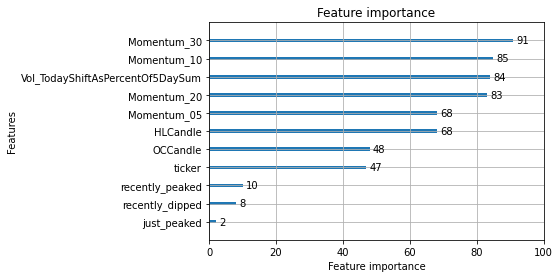

In [69]:
lgb.plot_importance(model)

# Finding the ideal holding time

In [ ]:
# Finds the highest number of times where holding for this many days would result in atleast an {acceptable_gains} amount

plays = dict()
for i in tqdm(range(1, 300)):
    value_count = df_augmented[f"MakesBigMoney_{i}Days"].value_counts()
    plays[str(i).rjust(3, '0')] = 0 if True not in value_count.keys() else value_count[True]

plays

In [ ]:
max_point = max(list(plays.values()))
max_point

In [ ]:
days_to_hold = list(plays.values()).index(max_point)
days_to_hold

In [ ]:
# Holding for 10 days gives
round(100.0 * (plays["010"] / df_augmented.shape[0]), 2) 

In [ ]:
go.Figure(
    go.Scatter(
        x=list(plays.keys()),
        y=list(plays.values())
    )
)

# Exploration Graphs

In [ ]:
go.Figure(
    go.Candlestick(
        x=list(df["Date"]),
        open=list(df[col_open]),
        close=list(df[col_close]),
        high=list(df[col_high]),
        low=list(df[col_low])
    )
)

In [ ]:
go.Figure(
    go.Scatter(
        x=list(df["Date"]),
        y=list(df[col_close]),
        name="Close"
    )
)

In [ ]:
go.Figure(
    go.Bar(
        x=list(df["Date"]),
        y=list(df["just_peaked"]),
        name="Peak"
    )
).add_trace(
    go.Bar(
        x=list(df["Date"]),
        y=list(df["just_dipped"]),
        name="Dip"
    )
)